# Multi-Template Hybrid Model Development

can we develop a multi-template hybrid model that can be trained on LHS data from one
template and then used to predict the response of another template?

we may want to use minimal data from the second template to fine-tune the model, but
the goal is to have a model that can generalize across different templates.

we can start with the eGFP kinetic model and then identify multi-template structure
that can be used to train the machine learning model.


In [18]:
import r3.adapters as adapters
import r3.schema as schema
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

X_columns = [
    schema.IVTReactionSchema.NTP_M.value,
    schema.IVTReactionSchema.T7RNAP_u_uL.value,
    schema.IVTReactionSchema.DNA_ug_mL.value,
    schema.IVTReactionSchema.Mg2_M.value,
    schema.IVTReactionSchema.TIME_min.value,
]
y_columns = [schema.IVTReactionSchema.RNA_g_L.value]
experimental_conditions, response = adapters.DataPipelineAdapter(
    "egfp_lhs", verbose=False
).get(X_columns=X_columns, y_columns=y_columns)
experimental_data = experimental_conditions
experimental_data[y_columns[0]] = response[y_columns[0]]
experimental_data

,NTPs [M],T7RNAP [units/uL],DNA [µg/mL],Mg2+ [M],Reaction Time [min],RNA [g/L]
0,0.052,342,27,0.079,126.0,5.625938
1,0.012,210,29,0.088,114.0,2.049225
2,0.020,135,21,0.050,240.0,2.395913
3,0.040,378,97,0.045,42.0,9.591750
4,0.020,246,83,0.070,192.0,5.397412
5,0.048,213,98,0.067,18.0,5.246775
6,0.040,195,24,0.041,54.0,3.955950
7,0.056,271,94,0.007,108.0,0.083775
8,0.016,186,53,0.062,54.0,3.621188
9,0.052,288,66,0.010,138.0,0.140887


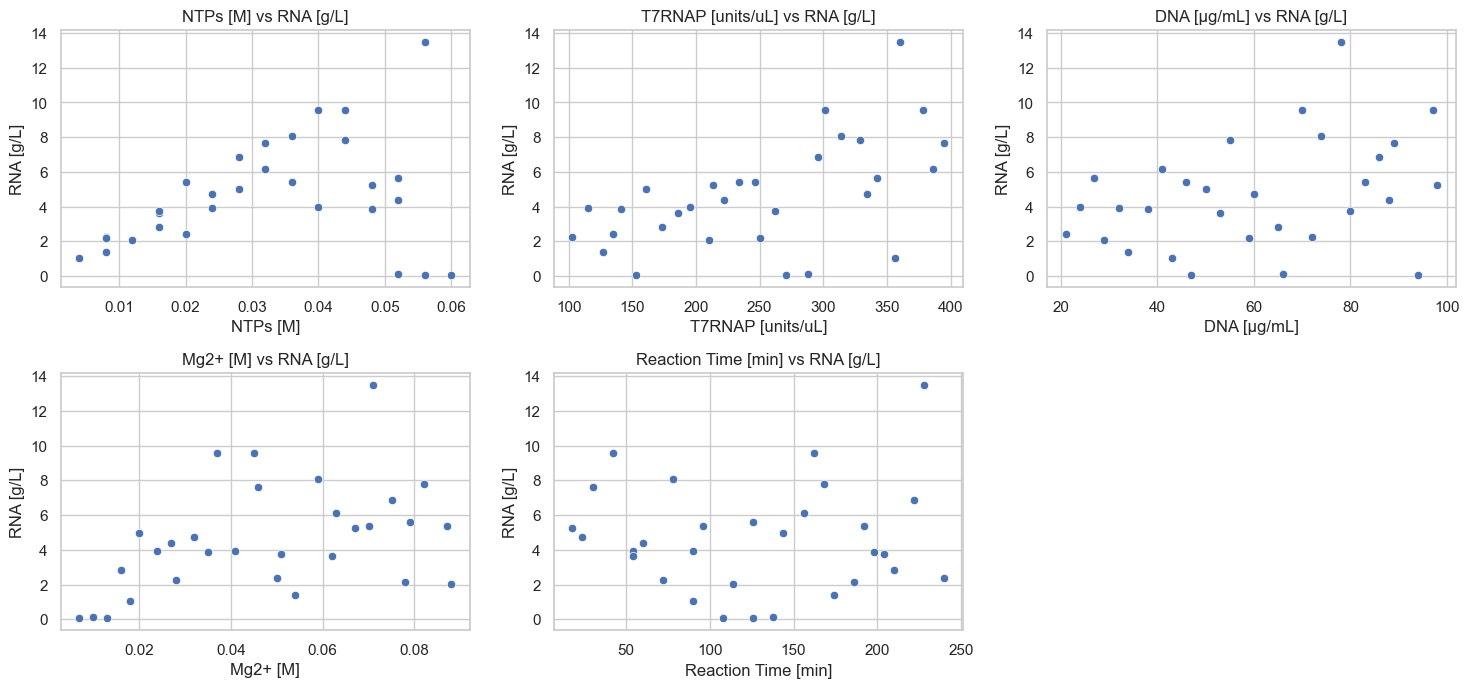

In [19]:
# plot the experimental conditions against the response in a grid
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
for i, col in enumerate(X_columns):
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(data=experimental_data, x=col, y=y_columns[0])
    plt.title(f"{col} vs {y_columns[0]}")
    plt.xlabel(col)
    plt.ylabel(y_columns[0])
plt.tight_layout()

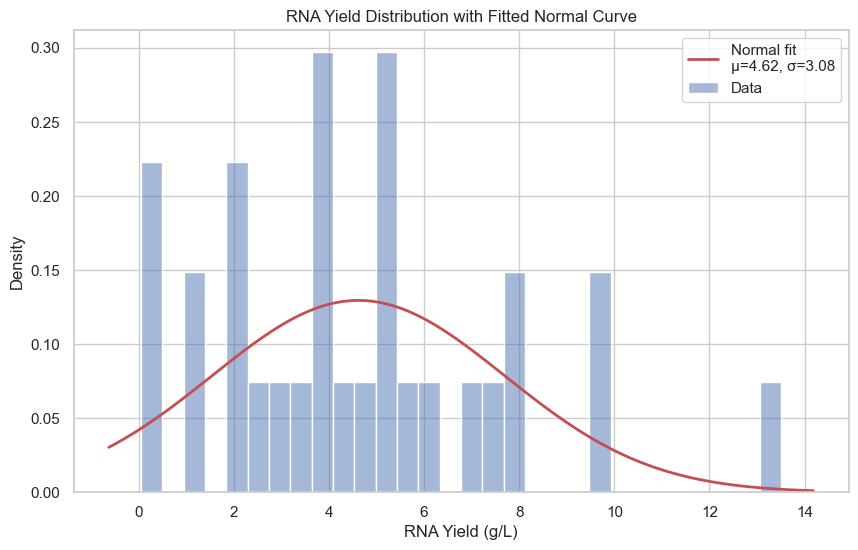

In [20]:
# Fit a normal distribution
mu, std = stats.norm.fit(response.values)

# Plot histogram and fitted PDF
plt.figure(figsize=(10, 6))
sns.histplot(
    response.values, bins=30, kde=False, stat="density", color="skyblue", label="Data"
)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, "r", linewidth=2, label=f"Normal fit\nμ={mu:.2f}, σ={std:.2f}")
plt.title("RNA Yield Distribution with Fitted Normal Curve")
plt.xlabel("RNA Yield (g/L)")
plt.ylabel("Density")
plt.legend()
plt.show()

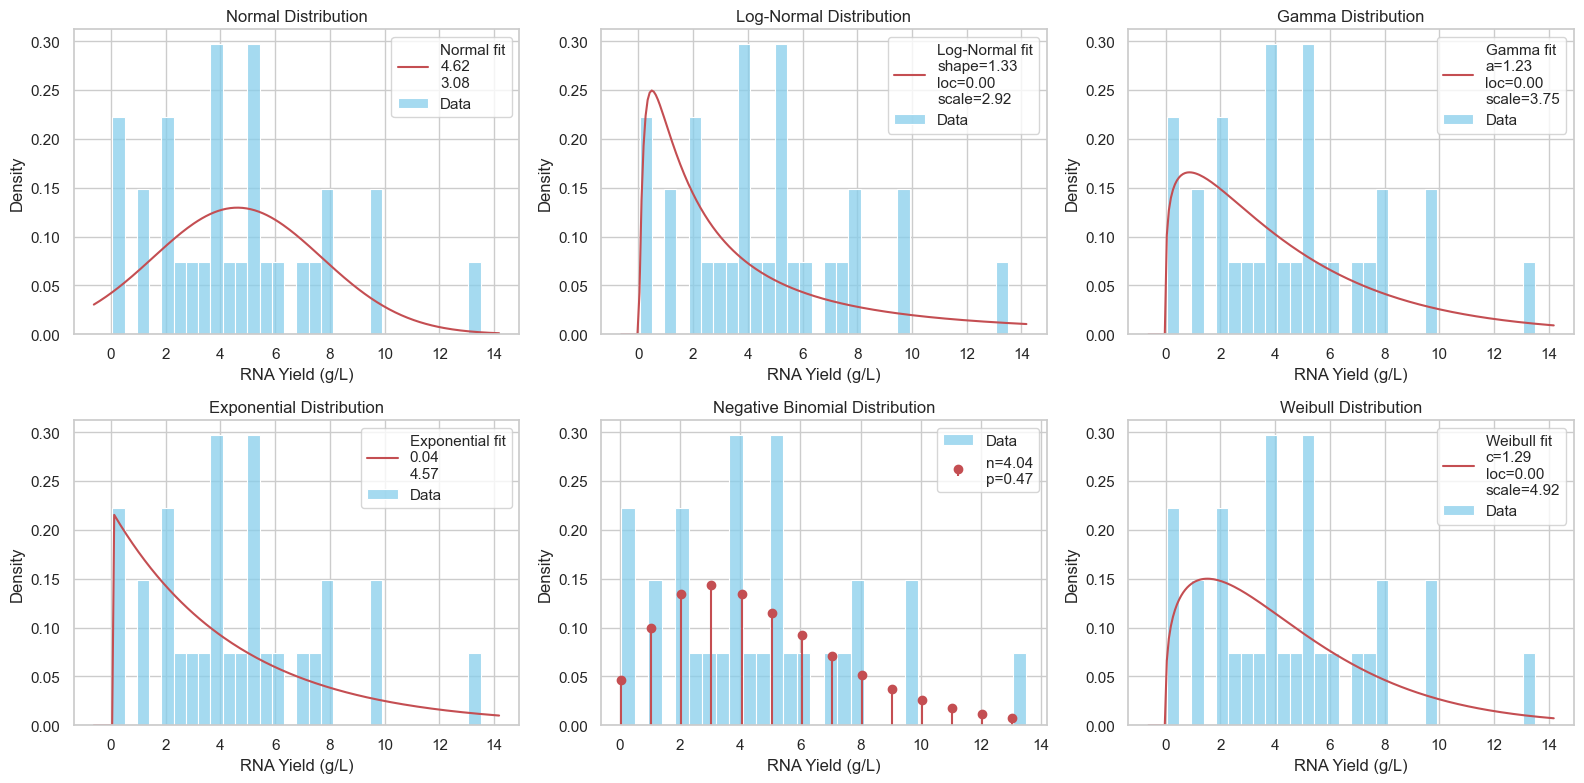

Normality Tests:
Shapiro-Wilk: W=0.954, p=0.215
Anderson-Darling: statistic=0.338, critical_values=[0.521 0.593 0.712 0.83  0.988]

Goodness-of-fit (Kolmogorov-Smirnov) for each distribution:
Normal: KS statistic=0.105, p=0.861
Log-Normal: KS statistic=0.231, p=0.0692
Gamma: KS statistic=0.104, p=0.869
Exponential: KS statistic=0.209, p=0.125
Negative Binomial: KS statistic=0.224, p=0.0826
Weibull: KS statistic=0.158, p=0.404


In [21]:
rna_yield = response[y_columns[0]].dropna().values

# List of distributions to fit (Beta removed)
distributions = {
    "Normal": stats.norm,
    "Log-Normal": stats.lognorm,
    "Gamma": stats.gamma,
    "Exponential": stats.expon,
    "Negative Binomial": stats.nbinom,
    "Weibull": stats.weibull_min,
}

plt.figure(figsize=(16, 8))
for i, (name, dist) in enumerate(distributions.items(), 1):
    plt.subplot(2, 3, i)
    sns.histplot(
        rna_yield, bins=30, kde=False, stat="density", color="skyblue", label="Data"
    )
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 200)
    if name == "Log-Normal":
        shape, loc, scale = dist.fit(rna_yield, floc=0)
        pdf = dist.pdf(x, shape, loc, scale)
        label = f"shape={shape:.2f}\nloc={loc:.2f}\nscale={scale:.2f}"
    elif name == "Gamma":
        a, loc, scale = dist.fit(rna_yield, floc=0)
        pdf = dist.pdf(x, a, loc, scale)
        label = f"a={a:.2f}\nloc={loc:.2f}\nscale={scale:.2f}"
    elif name == "Negative Binomial":
        data_nb = np.round(rna_yield - rna_yield.min()).astype(int)
        data_nb = data_nb[data_nb >= 0]
        mean_nb = np.mean(data_nb)
        var_nb = np.var(data_nb)
        if var_nb > mean_nb:
            p = mean_nb / var_nb
            n = mean_nb * p / (1 - p)
            x_nb = np.arange(data_nb.min(), data_nb.max() + 1)
            pmf = stats.nbinom.pmf(x_nb, n, p)
            plt.stem(
                x_nb + rna_yield.min(),
                pmf,
                linefmt="r-",
                markerfmt="ro",
                basefmt=" ",
                label=f"n={n:.2f}\np={p:.2f}",
            )
            label = f"n={n:.2f}\np={p:.2f}"
        else:
            label = "var <= mean, NB not valid"
        pdf = None
    elif name == "Weibull":
        c, loc, scale = dist.fit(rna_yield, floc=0)
        pdf = dist.pdf(x, c, loc, scale)
        label = f"c={c:.2f}\nloc={loc:.2f}\nscale={scale:.2f}"
    else:
        params = dist.fit(rna_yield)
        pdf = dist.pdf(x, *params)
        label = "\n".join([f"{p:.2f}" for p in params])
    if name != "Negative Binomial":
        plt.plot(x, pdf, "r", label=f"{name} fit\n{label}")
    plt.title(f"{name} Distribution")
    plt.xlabel("RNA Yield (g/L)")
    plt.ylabel("Density")
    plt.legend()
plt.tight_layout()
plt.show()

# Statistical tests
print("Normality Tests:")
shapiro_stat, shapiro_p = stats.shapiro(rna_yield)
print(f"Shapiro-Wilk: W={shapiro_stat:.3f}, p={shapiro_p:.3g}")
ad_result = stats.anderson(rna_yield, dist="norm")
print(
    f"Anderson-Darling: statistic={ad_result.statistic:.3f}, critical_values={ad_result.critical_values}"
)

print("\nGoodness-of-fit (Kolmogorov-Smirnov) for each distribution:")
for name, dist in distributions.items():
    try:
        if name == "Log-Normal":
            params = dist.fit(rna_yield, floc=0)
            d_stat, p_val = stats.kstest(rna_yield, "lognorm", args=params)
        elif name == "Negative Binomial":
            data_nb = np.round(rna_yield - rna_yield.min()).astype(int)
            data_nb = data_nb[data_nb >= 0]
            mean_nb = np.mean(data_nb)
            var_nb = np.var(data_nb)
            if var_nb > mean_nb:
                p = mean_nb / var_nb
                n = mean_nb * p / (1 - p)
                d_stat, p_val = stats.kstest(data_nb, "nbinom", args=(n, p, 0))
                print(f"{name}: KS statistic={d_stat:.3f}, p={p_val:.3g}")
            else:
                print(f"{name}: KS test not valid (var <= mean)")
            continue
        elif name == "Weibull":
            params = dist.fit(rna_yield, floc=0)
            d_stat, p_val = stats.kstest(rna_yield, "weibull_min", args=params)
        elif name == "Normal":
            params = dist.fit(rna_yield)
            d_stat, p_val = stats.kstest(rna_yield, "norm", args=params)
        elif name == "Exponential":
            params = dist.fit(rna_yield)
            d_stat, p_val = stats.kstest(rna_yield, "expon", args=params)
        else:
            params = dist.fit(rna_yield)
            d_stat, p_val = stats.kstest(rna_yield, name.lower(), args=params)
        print(f"{name}: KS statistic={d_stat:.3f}, p={p_val:.3g}")
    except Exception as e:
        print(f"{name}: KS test not available ({e})")

**Statistical significance** in this context means the test **rejects the null
hypothesis** (i.e., the data does **not** follow the distribution) if the p-value is
**less than 0.05**.

- **Shapiro-Wilk (Normality):** p = 0.215 (> 0.05) → **Do not reject normality**
- **Anderson-Darling (Normality):** statistic = 0.338 < 0.521 (critical value for
  15%) → **Do not reject normality**

**KS Goodness-of-fit (all p > 0.05):**

- Normal: p = 0.861
- Log-Normal: p = 0.0692
- Gamma: p = 0.869
- Exponential: p = 0.125
- Negative Binomial: p = 0.0826
- Weibull: p = 0.404

**Conclusion:**  
**None** of the distributions are statistically rejected (all p > 0.05).  
**Normal and Gamma** have the highest p-values, suggesting they fit your data best.  
You can say your data is statistically consistent with all these distributions.


## Identify trends in the data

Can we find statistically significant features that can explain the variance in the
data to identify statistically significant features.


In [22]:
X_train, y_train = experimental_conditions[X_columns], response[y_columns[0]]

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

df = pd.DataFrame(X_train_scaled, columns=X_columns)
df[y_columns[0]] = y_train_scaled
df

,NTPs [M],T7RNAP [units/uL],DNA [µg/mL],Mg2+ [M],Reaction Time [min],RNA [g/L]
0,1.207950e+00,1.068483,-1.426386,1.275418,-0.012254,0.327373
1,-1.207950e+00,-0.451342,-1.339851,1.643721,-0.196072,-0.833847
2,-7.247702e-01,-1.314878,-1.685991,0.088665,1.734011,-0.721291
3,4.831801e-01,1.482980,1.602341,-0.115947,-1.298977,1.614917
4,-7.247702e-01,-0.036844,0.996595,0.907116,0.998742,0.253179
5,9.663603e-01,-0.416800,1.645608,0.784348,-1.666612,0.204273
6,4.831801e-01,-0.624049,-1.556189,-0.279637,-1.115159,-0.214807
7,1.449540e+00,0.251001,1.472538,-1.671003,-0.287981,-1.471952
8,-9.663603e-01,-0.727674,-0.301430,0.579736,-1.115159,-0.323492
9,1.207950e+00,0.446736,0.261047,-1.548235,0.171563,-1.453410


## Identifying Latent Variables

We start from Partial Least Squares (PLS) regression, to identify latent variables that explain the variance in the data.

<div style="text-align: center;">
  <img src="../../assets/pls.png" alt="PLS diagram">
</div>

Where $\mathbf{X}$ is the input data matrix, $\mathbf{Y}$ is the output data matrix, $\mathbf{T}$ and $\mathbf{U}$ are the latent variables, $\mathbf{P}$ and $\mathbf{Q}$ are the loadings, and $\mathbf{E}$ and $\mathbf{F}$ are the residuals.
We can express the PLS regression model as follows:

$$
\begin{aligned}
& \mathbf{X}=\mathbf{T} \mathbf{P}^T+\mathbf{E} \\
& \mathbf{Y}=\mathbf{U} \mathbf{Q}^T+\mathbf{F}
\end{aligned}
$$

Best number of components: 1
R-squared: 0.48289034909157347
Root Mean Squared Error: 2.21493571755829


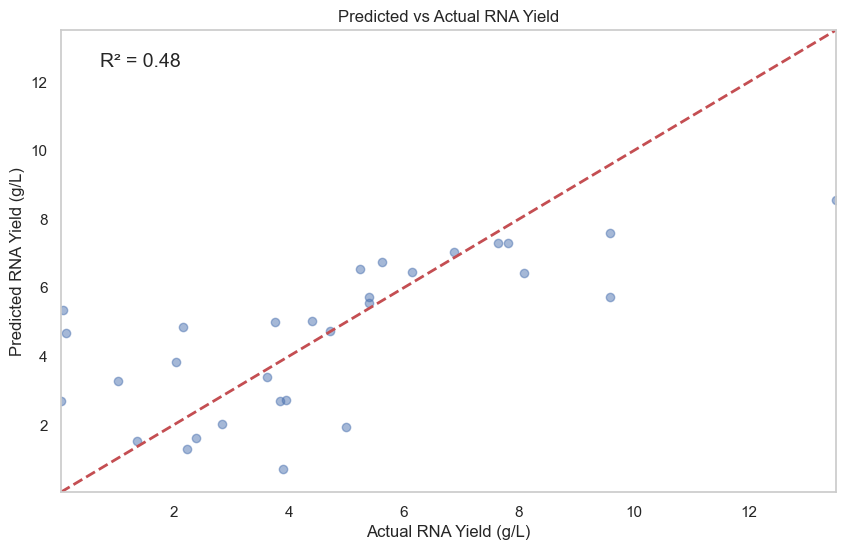

In [ ]:
# Create a PLS model
pls = PLSRegression()

# Use GridSearchCV to find the best number of components using KFold cross-validation
param_grid = {"n_components": list(range(1, 10))}
kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(pls, param_grid, cv=kf, scoring="neg_mean_squared_error")
grid_search.fit(X_train_scaled, y_train_scaled)

# Best number of components
best_n_components = grid_search.best_params_["n_components"]
print(f"Best number of components: {best_n_components}")

# Fit the PLS model with the best number of components
pls_best = PLSRegression(n_components=best_n_components)
pls_best.fit(X_train_scaled, y_train_scaled)

# Predict on the test set
Y_pred_scaled = pls_best.predict(X_train_scaled)

# Inverse transform the predicted values
predictions = scaler_y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()

# Calculate mean squared error and root mean squared error for the predictions
rmse = np.sqrt(mean_squared_error(y_train, predictions))
# Calculate R-squared for the predictions
r2 = r2_score(y_train, predictions)

# Print results
print(f"R-squared: {r2}")
print(f"Root Mean Squared Error: {rmse}")


# Plot the predicted vs actual RNA yield
plt.figure(figsize=(10, 6))
plt.scatter(y_train, predictions, alpha=0.5)
plt.text(
    0.05,
    0.95,
    f"R² = {r2:.2f}",
    transform=plt.gca().transAxes,
    fontsize=14,
    verticalalignment="top",
)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2)
plt.title("Predicted vs Actual RNA Yield")
plt.xlabel("Actual RNA Yield (g/L)")
plt.ylabel("Predicted RNA Yield (g/L)")
plt.xlim(y_train.min(), y_train.max())
plt.ylim(y_train.min(), y_train.max())
plt.grid()